In [43]:
%matplotlib inline 
import itertools
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import sys

from collections import defaultdict
from sklearn import metrics

In [44]:
import seaborn as sns
sns.set_style('white')
sns.set_palette('colorblind')

In [45]:
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)
from preprocess import essay_documents, process_arg_essays_for_conll

In [46]:
ANNOTATIONS_DIR = '/home/milagro/FaMAF/am/third_party/brat-v1.3_Crunchy_Frog/data/'
ANNOTATORS = {
    'mili': {'dirname': 'judgements-mili'},
    # 'laura': {'dirname': 'judgements-laura'},
    'serena': {'dirname': 'judgements-serena'}
}
ANNOTATION_FORMAT = r'.*\.ann'
BRAT_DIRNAME = '/home/milagro/FaMAF/am/third_party/brat/'

### Find files to compare

In [47]:
def get_non_empty_files(input_dirpath, pattern, size_limit=500):
    """Returns the names of the files in input_dirpath matching pattern."""
    all_files = os.listdir(input_dirpath)
    result = {}
    for filename in all_files:
        if not re.match(pattern, filename):
            continue
        filepath = os.path.join(input_dirpath, filename)
        if os.path.isfile(filepath) and os.stat(filepath).st_size > 500:
            result[filename] = filepath
    return result

In [48]:
files = defaultdict(lambda: {})
for name, annotator in ANNOTATORS.items():
    annotator['files'] = get_non_empty_files(os.path.join(ANNOTATIONS_DIR, annotator['dirname']),
                                             ANNOTATION_FORMAT)
    for filename, filepath in annotator['files'].items():
        files[filename][name] = filepath

In [49]:
ANNOTATORS

{'mili': {'dirname': 'judgements-mili',
  'files': {'CASE_OF__ALKASI_v._TURKEY.ann': '/home/milagro/FaMAF/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-mili/CASE_OF__ALKASI_v._TURKEY.ann',
   'CASE_OF__BARCZA_AND_OTHERS_v_HUNGARY.ann': '/home/milagro/FaMAF/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-mili/CASE_OF__BARCZA_AND_OTHERS_v_HUNGARY.ann'}},
 'serena': {'dirname': 'judgements-serena',
  'files': {'CASE_OF__ALKASI_v._TURKEY.ann': '/home/milagro/FaMAF/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-serena/CASE_OF__ALKASI_v._TURKEY.ann'}}}

In [50]:
dict(files)

{'CASE_OF__ALKASI_v._TURKEY.ann': {'mili': '/home/milagro/FaMAF/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-mili/CASE_OF__ALKASI_v._TURKEY.ann',
  'serena': '/home/milagro/FaMAF/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-serena/CASE_OF__ALKASI_v._TURKEY.ann'},
 'CASE_OF__BARCZA_AND_OTHERS_v_HUNGARY.ann': {'mili': '/home/milagro/FaMAF/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-mili/CASE_OF__BARCZA_AND_OTHERS_v_HUNGARY.ann'}}

Find pairs of files annotated for more than one annotator.

In [51]:
from imp import reload
reload(process_arg_essays_for_conll)
reload(essay_documents)

<module 'preprocess.essay_documents' from '/home/milagro/FaMAF/am/argument_mining/preprocess/essay_documents.py'>

In [52]:
document_pairs = []
for value in files.values():
    if len(value) < 2:
        continue
    annotations = {}
    for name, filename in value.items():
        with process_arg_essays_for_conll.EssayDocumentFactory(
                filename.replace('ann', 'txt'), '-' + name) as instance_extractor:
            annotations[name] = instance_extractor.build_document()
    for ann1, ann2 in list(itertools.combinations(annotations.keys(), 2)):
        document_pairs.append((annotations[ann1], annotations[ann2]))

In [53]:
document_pairs

[(CASE_OF__ALKASI_v._TURKEY.txt-serena, CASE_OF__ALKASI_v._TURKEY.txt-mili)]

In [54]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [55]:
printmd(document_pairs[0][0].sample_labeled_text(limit=40, styles={'claim': '_', 'major-claim': '**', 'premise': '`'}))

Relying on Article 6 of the Convention , the applicant complains that _the_ _labour_ _court’s_ _dismissal_ _of_ _her_ _claim_ _for_ _compensation_ _against_ _her_ _former_ _employer_ _amounted_ _to_ _a_ _violation_ _of_ _her_ _right_ _to_ _be_ _presumed_ _innocent_ , in that `the` `labour` `court` `found` `that` `she` `had` `broken` `her` `employer’s` `trust` `by` `committing` `the` offence `of` `incitement` . 

The applicant argues that **the** **labour** **court’s** **complete** **disregard** **of** **her** **acquittal** **in** **relation** **to** **the** **charge** **of** **incitement** **is** **incompatible** **with** **the** **requirements** **of** **Article** **6** **§** **2** **of** **the** **Convention** . 

She further claims that _the_ _Bakırköy_ _Labour_ _Court_ _based_ _its_ _decision_ on _self-incriminating_ _statements_ _which_ _she_ _had_ _given_ _to_ _the_ _police_ _in_ _the_ _absence_ _of_ _her_ _lawyer_ . 

Being the master of the characterisation to be given in law to the facts of the case , the Court considers that _the_ _applicant’s_ _grievances_ _fall_ _to_ _be_ _examined_ _solely_ _under_ _Article_ _6_ _§_ _2_ _of_ _the_ _Convention_ which reads as follows : 

`“Everyone` `charged` `with` `a` `criminal` `offence` `shall` `be` `presumed` `innocent` `until` `proved` `guilty` `according` `to` `law.”` 

In their submissions , the Government maintained that **the** **applicant’s** **dismissal** **at** **the** **material** **time** **had** **been** **based** **on** **the** **self-incriminating** **statements** **she** **had** **given** **to** **the** **police** . 



# Compare document annotations

## Token level comparison

In [56]:
def get_labels(doc1, doc2):
    words1, labels1 = doc1.get_word_label_list()
    words2, labels2 = doc2.get_word_label_list()
    # Check the documents are equal
    assert words1 == words2
    return labels1, labels2

In [57]:
def show_kappa(labels1, labels2):
    kappa = metrics.cohen_kappa_score(labels1, labels2)
    print('{}-{}: {}'.format(doc1.identifier.split('-')[1], doc2.identifier.split('-')[1], kappa))

In [58]:
def show_confusion_matrix(labels1, labels2):
    label_names = list(set(labels1))
    matrix = metrics.confusion_matrix(labels1, labels2, labels=label_names)
    sns.heatmap(matrix, annot=True, fmt="d", linewidths=.5,
                xticklabels=label_names, yticklabels=label_names)
    plt.show()

Kappa agreement using labels `claim`, `major-claim` and `premise`

serena-mili: 0.5083266031335809


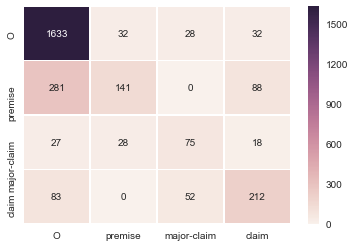

In [59]:
for doc1, doc2 in document_pairs:
    labels1, labels2 = get_labels(doc1, doc2)
    show_kappa(labels1, labels2)
    show_confusion_matrix(labels1, labels2)

Kappa agreement using only labels `claim` and `premise`

serena-mili: 0.5468929888071954


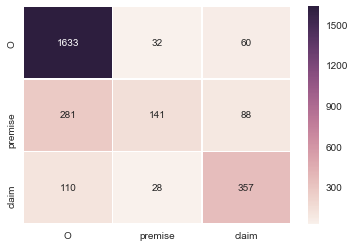

In [60]:
for doc1, doc2 in document_pairs:
    labels1, labels2 = get_labels(doc1, doc2)
    labels1 = [x if x != 'major-claim' else 'claim' for x in labels1]
    labels2 = [x if x != 'major-claim' else 'claim' for x in labels2]
    show_kappa(labels1, labels2)
    show_confusion_matrix(labels1, labels2)